# Анализ данных интернет-магазина видеоигр

Из открытых источников получены исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Цель исследования - выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

*В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».*

Путь к исходному датасету: /datasets/games.csv/

Описание данных
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
# импорт библиотек для работы
import pandas as pd
import numpy as np

# построение графиков
import matplotlib.pyplot as plt
import seaborn as sns

# статистика
from scipy import stats as st

## Общая информация о датасете

In [2]:
# чтение файла
try:
    df = pd.read_csv('/datasets/games.csv')
except FileNotFoundError:
    df = pd.read_csv('games.csv')
    
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
12070,Target: Terror,Wii,2008.0,Shooter,0.06,0.00,0.00,0.01,33.0,2.7,M
2748,Band Hero,PS3,2009.0,Misc,0.41,0.23,0.00,0.11,76.0,5.7,E10+
5458,Hulk,XB,2003.0,Action,0.25,0.07,0.00,0.01,69.0,7.7,T
5485,Classic NES Series: Castlevania,GBA,2004.0,Platform,0.17,0.06,0.09,0.01,74.0,8.6,E
15954,Post Mortem,PC,2003.0,Adventure,0.00,0.01,0.00,0.00,71.0,8,M


Названия столбцов необходимо будет привести к нижнему регистру, рассмотрим типы данных в датасете и уникальные значения в категориальных переменных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В датасете 16715 строк, основные пропуски в столбцах critic_score, user_score, rating. От строк с пропусками в Year_of_release, Genre, Name - избавимся, так как их общее количество слишком небольшое для того, чтобы повлиять на статистические данные и итоговые показатели.

Пользовательский рейтинг и рейтинг критиков имеют большое количество NaN значений, поэтому оставим во float формате. Пропуски могут быть связаны с отсутствием достаточного количества оценок для формирования средней, либо игра слишком устаревшая и в интернете отсутствует оцифрованная критика по старым играм.

Год релиза можно перевести в формат даты, либо числовой int, так как день и месяц отсутствуют - переведем столбец к int формату.

Информация о продажах представлена в миллионах копий, возможно в дальнейшем потребуется перевести данные в тысячи, но на данном этапе оставим их в миллионах копий в формате float.

In [4]:
# значения в столбце platform

df['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

В датасете представлены данные для консолей разных поколений и типов, а также PC. Неявных дубликатов среди списка значений нет.

In [5]:
# значения в столбце Genre

df['Genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

Среди жанров также нет дубликатов: спортивные игры, платформеры, гонки, ролевые игры, пазлы, прочие (невошедшие в другие жанры), шутеры, симуляторы, экшн, файтинг, адвентуры, стратегии.

In [6]:
# значения в столбце Raiting

df['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Среди значений:
- EC (Early childhood) - "для детей младшего возраста (от 3 лет)"
- E (Everyone) - "для всех (от 6 лет)"
- E10+ (Everyone 10 and older) - "для всех от 10 лет и старше"
- T (Teen) - "для подростков (от 13 лет)"
- M (Mature) - "для взрослых (от 17 лет)"
- AO (Adults only) - "только для взрослых (от 18 лет)"
- RP (Rating Pending) - "рейтинг ожидается" (ожидает присвоения рейтинга)

Категория K-A (kids to adults) - ранее использовалась вместо рейтинга E (Everyone), поэтому можно будет заменить рейтинг в играх с K-A на E.

In [7]:
# значения в столбце user_score

df['User_Score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.6       2
1.5       2
1.3       2
0         1
9.7       1
Name: User_Score, Length: 96, dtype: int64

Среди значений пользовательских оценок, помимо пропусков и численных значений, большое количество "tbd", что означает to be decided - "будет определено", так как у нас нет информации об оценках в указанных строках, значения tbd заменим на nan, чтобы преобразовать значения столбца к численному формату.

**Вывод**

Таким образом, мы дали первичную оценку данным в датасете и определили цели предобработки, заполнять столбцы с наибольшим количеством пропусков - рейтинг критиков, рейтинг игроков, возрастной рейтинг - мы не будем, так как заполнив пропуски средними или медианными значениями мы значительно исказим результаты корреляционного анализа и статистических тестов в дальнейшем.

Перейдем к предобработке данных.

## Предобработка данных

Для получения качественных данных необходимо осуществить следующие этапы предобработки, в соответствии с полученными ранее выводами:
- привести столбцы датасета к нижнему регистру;
- удалить строки с пропусками в столбцах year_of_release, genre, name;
- проверить датасет на наличие явных и неявных дубликатов и удалить дубликаты;
- привести типы данных в столбцах к соответствующим смыслу данных типам;
- расчитать общие продажи игр (сумма столбцов eu, na, jp, other sales).

Для начала приведем названия столбцов к нижнему регистру:

In [8]:
# приведение названий столбцов к нижнему регистру

df.columns = [x.lower() for x in df.columns]

Удалим строки с пропусками в столбцах year_of_release, genre, name

In [9]:
print('Строк всего до:', df['name'].count())

# удаление пропусков

df = df.dropna(subset=['year_of_release', 'name', 'genre'])

print('Строк всего после:', df['name'].count())

Строк всего до: 16713
Строк всего после: 16444


Проверим датасет на дубликаты и удалим их в случае наличия

In [10]:
# проверка на дубликаты

print('Дубликаты:', df.duplicated().sum())

Дубликаты: 0


Приступим к корректировке типов данных по столбцам

In [11]:
# изменение типа данных year_of_release

df['year_of_release'] = df['year_of_release'].astype(int)

Заменим tbd в столбце user_score на nan и преобразуем столбец к численному типу

In [12]:
# изменение tbd на nan

df['user_score'] = df['user_score'].replace('tbd', np.nan)

# преобразование типа данных

df['user_score'] = pd.to_numeric(df['user_score'])

Заменим рейтинг K-A в столбце rating на E:

In [13]:
# замена дубликата возврастного рейтинга

print('Количество K-A до:', df[df['rating'] == 'K-A']['rating'].count())
df['rating'] = df['rating'].replace('K-A', 'E')
print('Количество K-A после:', df[df['rating'] == 'K-A']['rating'].count())

Количество K-A до: 3
Количество K-A после: 0


Изменив типы данных и удалив часть пропусков мы можем посчитать суммарные продажи игр во всех регионах в новый столбец total_sales

In [14]:
# расчет общих продаж

df['total_sales'] = df['eu_sales'] + df['jp_sales'] + df['na_sales'] + df['other_sales']

Взглянем на полученный датасет перед проведением исследований

In [15]:
df.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
11385,Midnight Play! Pack,DS,2008,Misc,0.08,0.00,0.00,0.01,NaN,NaN,NaN,0.09
5694,F1 Race Stars,PS3,2012,Racing,0.06,0.19,0.00,0.06,61.0,5.6,E,0.31
5867,Looney Tunes: Duck Amuck,DS,2007,Action,0.28,0.00,0.00,0.02,66.0,NaN,E,0.30
14326,Call of Juarez: Bound in Blood,PC,2009,Shooter,0.00,0.03,0.00,0.00,78.0,8.0,M,0.03
2102,Tetris 2,NES,1993,Puzzle,0.62,0.13,0.21,0.02,NaN,NaN,NaN,0.98
14646,Mahjong Kakutou Club: Zenkoku Taisenban,PS3,2006,Misc,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03
5476,World Stadium 3,PS,1999,Sports,0.00,0.00,0.31,0.02,NaN,NaN,NaN,0.33
1396,LEGO Batman 2: DC Super Heroes,Wii,2012,Action,0.90,0.37,0.00,0.11,NaN,7.1,E10+,1.38
8731,NCAA Football 2004,GC,2003,Sports,0.12,0.03,0.00,0.00,89.0,7.5,E,0.15
15589,Elven Legacy,PC,2009,Strategy,0.02,0.00,0.00,0.00,71.0,7.1,T,0.02


**Вывод**

Датасет готов к дальнейшему анализу, мы изменили тип данных года релиза, рейтинга пользователей. Заменили пропуск в виде 'tba' в столбце `user_score` на NaN, заменили неявный дубликат в столбце `rating`, удалили строки с пропусками в столбцах `genre`, `year_of_release`, `name`.

Пропуски в столбцах с рейтингом мы решили оставить неизменными, так как они могут быть получены в связи с отсутствием или недостаточным количеством оценок на сайте-агрегаторе для расчета средней оценки игры.

Столбцы с количеством проданных копий оставили в предложенных единицах измерения (млн.копий), суммировали региональные продажи в общий столбец - `total_sales`.

## Исследовательский анализ данных видеоигр

Проведите исследовательский анализ данных
- Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрим, как менялись продажи по платформам. Определим платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Возьмем данные за соответствующий актуальный период. Актуальный период определим в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
- Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
- Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.
- Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.
- Соотнесем выводы с продажами игр на других платформах.
- Изучим общее распределение игр по жанрам.

Рассмотрим, сколько игр выходило по годам и их количество в исходном датасете

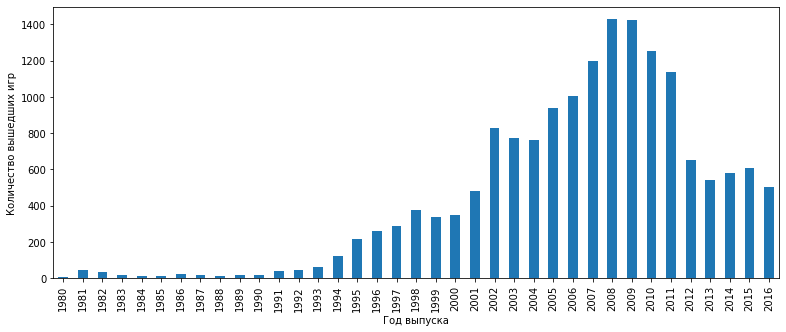

In [16]:
# количество выпущенных игр по годам

games_per_year = df.groupby('year_of_release')['name'].count()
games_per_year.plot(kind='bar', figsize=(13,5))
plt.xlabel('Год выпуска')
plt.ylabel('Количество вышедших игр')
plt.show()

Можно сделать вывод, что до 1994 года игр в год выходило меньше ста, начиная с 1994 года мы видим ежегодный прирост количества выпускаемых игр и резкий скачок в 2002 году. Далее график идет вниз и с 2005 года снова набирает тенденцию к увеличению вплоть до 2008 года. В 2008 и 2009 годах количество выпущенных игр самое высокое за весь рассматриваемый период, далее идет снижение числа вышедших в год игр и их резкое снижение в 2012 году. После 2012 года количество выпущенных игр +/- одинаковое.

Для планирования рекламных кампаний и выявления факторов успешности игр, нам необходимо выделить актуальные данные, которые можно соотнести с будущим периодом. Игры, вышедшие до двухтысячных годов выпускались на уже давно устаревшие платформы, такие как сега, геймбой, NES, dreamcast, ps1 и т.п. Учитывать продажи игр на устаревших консолях не имеет смысла. 

Чтобы определить, какие платформы являются актуальными, рассмотрим изменение общего количества проданных игр на разные платформы по годам и определим средний срок жизни платформ. Помимо списка актуальных платформ, средний срок жизни поможет определить актуальный период для построения дальнейших прогнозов на 2017 год.

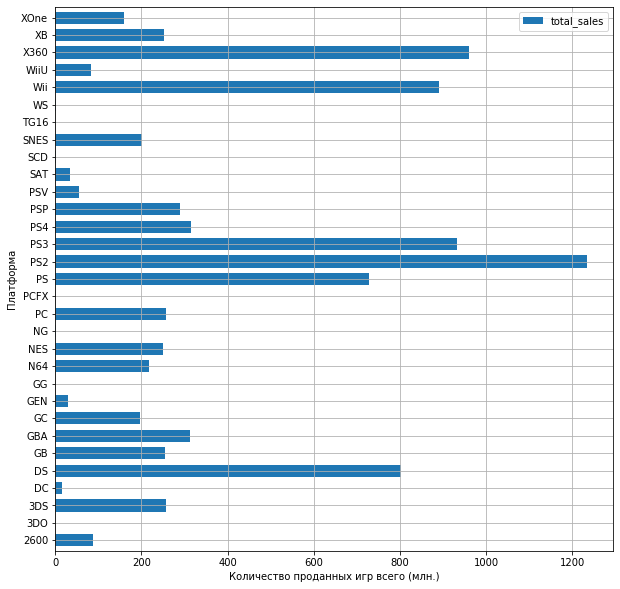

In [17]:
overal_sales_per_platform = df.groupby('platform').agg({'total_sales':'sum'})

overal_sales_per_platform.plot(kind='barh', figsize=(10,10), grid=True, width=0.7)
plt.xlabel('Количество проданных игр всего (млн.)')
plt.ylabel('Платформа')
plt.show()

Самые большие продажи у игр на PS2. Среди консолей следующего поколения, высокие и соразмерные продажи у лидеров рынка - X360, PS3, Wii. На диаграмме видно, что есть консоли, у которых слишком незначительный объем продаж игр, либо небольшое количество зафиксированной информации о продажах - к таким платформам относятся WS, TG16, SCD, PCFX, NG, GG, 3DO.

______

Рассмотрим платформы с наибольшим количеством проданных копий игр и изучим, как менялись продажи по годам.

In [18]:
# создание списка топ-10 платформ с наибольшими продажами

top_10_platforms = overal_sales_per_platform.sort_values(by='total_sales', ascending=False).head(10).index
top_10_platforms

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS'], dtype='object', name='platform')

In [19]:
# сводная таблица по топ-платформам и продажам по годам

df_sales_per_year = (df
    .query('platform in @top_10_platforms')
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
)

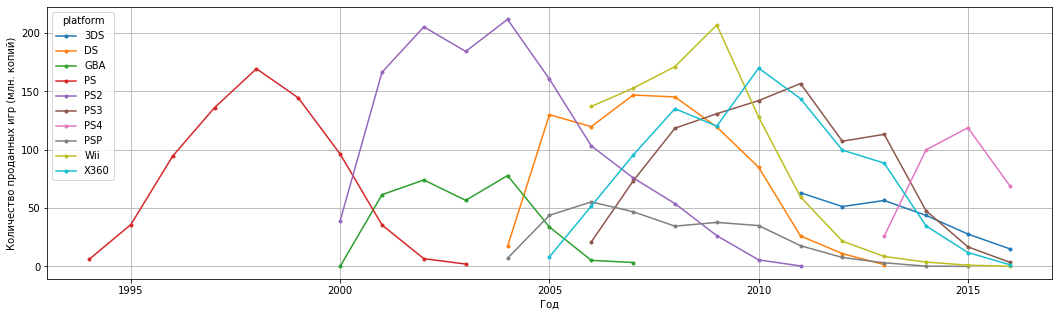

In [20]:
df_sales_per_year.plot(figsize=(18,5), grid=True, style='.-')
plt.xlim(1993,2017)
plt.xlabel('Год')
plt.ylabel('Количество проданных игр (млн. копий)')

plt.show()

Графики жизненного цикла платформ похожи на "горы", после релиза консоли, через 1-2 года наблюдается рост продаж игр на нее и после пика в середине жизненного цикла идет спад до полного отсутствия продаж примерно через 6-10 лет после выхода платформы. Закономерность не прослеживается только у персональных компьютеров, что логично, так как в наших данных нет различий PC по поколениям процессоров/видеокарт.

Также, по графикам можно заметить, что новые платформы появляются во время спада продаж платформ предыдущего поколения, так например график, относящийся к PS2, обрел тенденцию к спаду в 2004 году, в 2006 году, где продажи стали меньше пикового значения более чем в 2 раза, появляется PS3 - консоль нового поколения.

Определим среднюю продолжительность "жизни" платформ. Для этого отберем только те платформы, где общие продажи игр превышали 5 миллионов копий, чтобы исключить платформы с слишком низкими продажами в определенный год, либо с отсутствующей статистикой по продажам.

In [21]:
# отбор платформ с 5 млн. и более проданными копиями игр в год

platform_lifetime = df.groupby(['platform', 'year_of_release']).agg({'total_sales':'sum'}).query('total_sales > 5')

# расчет продолжительности среднего жизненного цикла по платформам

platform_lifetime = platform_lifetime.reset_index().groupby('platform').agg({'year_of_release':'nunique'}).mean()
print('Средняя продолжительность жизненного цикла платформы:', platform_lifetime['year_of_release'])

Средняя продолжительность жизненного цикла платформы: 6.916666666666667


Таким образом, средняя продолжительность жизни платформы - 7 лет, при этом, новое поколение платформ появляется уже на 5-6 год жизненного цикла платформы.

Актуальными данными будем считать те, которые соответствуют 7 годам до 2017 (прогнозного) года. В таком случае мы захватим и предыдущее поколение, продажи которого снижаются, и новые актуальные платформы, продажи по которым только набирают темпы роста.

In [22]:
# срез актуальных данных

df_new = df.query('year_of_release >= 2010')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5277 entries, 14 to 16714
Data columns (total 12 columns):
name               5277 non-null object
platform           5277 non-null object
year_of_release    5277 non-null int64
genre              5277 non-null object
na_sales           5277 non-null float64
eu_sales           5277 non-null float64
jp_sales           5277 non-null float64
other_sales        5277 non-null float64
critic_score       2312 non-null float64
user_score         2499 non-null float64
rating             3113 non-null object
total_sales        5277 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 535.9+ KB


В актуальном датасете осталось 5277 строк, рассмотрим, какие платформы лидируют по продажам, в каких наблюдается рост и спад.

In [23]:
# сводная таблица по актуальным данным с общими продажами в год

df_new_sales_per_year = df_new.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

df_new_sales_per_year

platform,3DS,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,,
2010,NaN,85.02,24.28,5.64,142.17,NaN,35.04,NaN,127.95,NaN,170.03,NaN
2011,63.20,26.18,35.03,0.45,156.78,NaN,17.82,4.63,59.65,NaN,143.84,NaN
2012,51.36,11.01,23.22,NaN,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,NaN,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,NaN,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,NaN,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,NaN,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


По данным таблицы можно сделать вывод, что платформы DS, PS2, PSP - уже можно считать не актуальными, так как по ним отсутствуют продажи в последних нескольких или последнем наблюдаемом периоде.

Также, тенденция к спаду продаж заметна на платформах, у которых жизненный цикл подходит к концу - это PS3, PSV, Wii, X360. Продажи в 2016 у указанных платформ уже в значительной степени ниже их пиковых значений, продавать игры для данных консолей не лучшее решение.

Платформа WiiU существует 5 лет, если исходить из среднего срока жизни платформ, то играм на данную консоль осталось продаваться еще 1-2 года. Портативная приставка нинтендо 3DS, несмотря на уже длительный срок жизни и заметное снижение продаж, по сравнению с пиковыми значениями в 2011-2013 годах, имеет высокие объемы продаж за 2016 год, которые в 3 раза выше другой приставки данного производителя WiiU.

**Вывод**

Наиболее перспективными платформами являются PS4 и XOne, также стоит отметить, что PC, как платформа, не подвержен устареванию и будет актуален всегда, несмотря на более низкие объемы продаж, чем у специализированных игровых платформ.
____
Построим графики boxplot по глобальным продажам игр в разбивке по платформам и рассмотрим их.

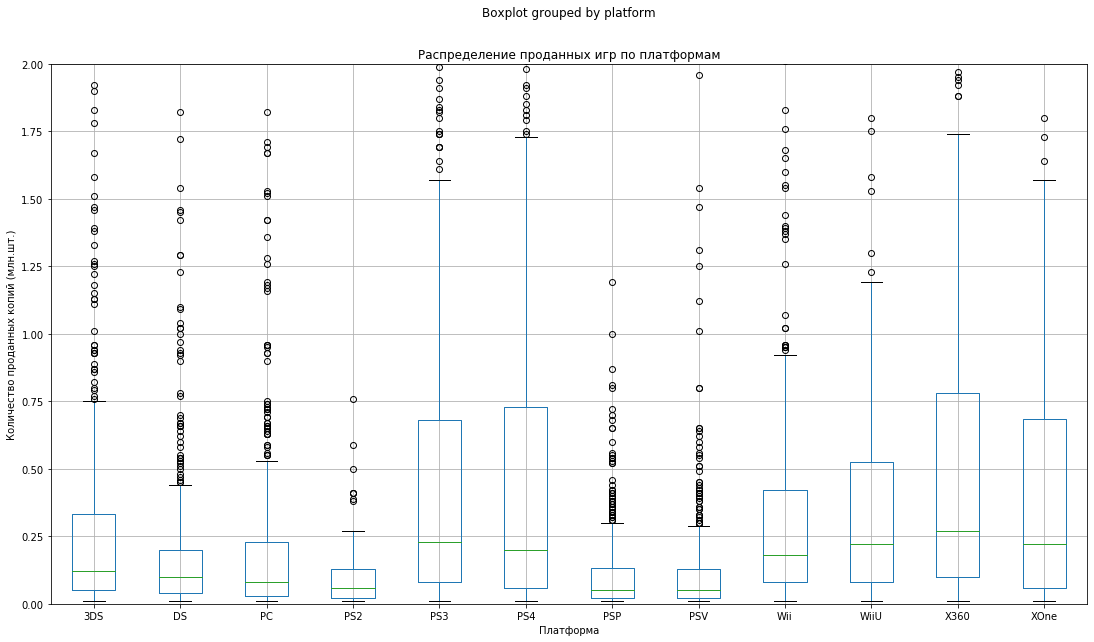

In [24]:
# отключение ошибки VisibleDeprecationWarning

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# построение "ящиков с усами" по количеству проданных игр на платформы по актуальным данным

df_new.boxplot(column = 'total_sales',
              by = 'platform',
              figsize=(18,10))
plt.ylim(0,2)
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий (млн.шт.)')
plt.title('Распределение проданных игр по платформам')
plt.show()

Медианные продажи игр на всех платформах не превышают 250 тысяч копий, кроме платформы X360, на которой среднее количество продаж по играм чуть больше 250 тысяч.

По графикам видно, что наименьший размах и общие продажи игр у платформ с истекшим сроком актуальности - PSP, PSV, PS2, DS - медианные продажи по актуальным годам не более 100 тысяч копий.

Широкий размах у PS4 - несмотря на то, что медиана количества продаж на данную платформу ниже, чем у консоли предыдущего поколения PS3, верхний ус находится близко к 1,75 млн. копий, в то же время у PS3 чуть выше 1,5.

Самый широкий размах и медианное значение проданных копий у X360, при этом, более новая платформа XOne имеет медианное значение немного ниже и не такой широкий размах. Диапазон значений платформы WiiU - от 0 до 1,2 млн без учета игр с аномально высокими продажами, данная платформа имеет более высокие показатели (медиана, размах значений), чем Wii, что логично, так как она вышла позже, а Wii, несмотря на медианное значение проданных копий игры в 2016 году имеет низкие показатели общих продаж.

**Вывод**

Таким образом, самые высокие медианные продажи у Xbox360, за ней идет PS3 и WiiU. Это может быть связано с выходом определенных эксклюзивов на данные платформы, имеющих высокий спрос. Следом за ними идут платформы текущего поколения - PS4 и Xbox One, их медианные значения продаж не сильно ниже и сопоставимы с предыдущим поколением. Wii также имеет высокое медианное значение и достаточно широкий размах, но по общим продажам ранее мы сделали вывод, что платформа к 2016 году уже устарела.

_____

Далее рассмотрим популярные платформы и как на продажи влияют отзывы пользователей и критиков. Возьмем платформы с самыми высокими общими продажами (PS3, X360,3DS,Wii) а также актуальные, более новые платформы (PS4, Xbox One).

In [25]:
# список платформ из актуального списка с самыми высокими продажами

platforms_list = df_new.pivot_table(index='platform', values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False).head(6).index

Построим для полученных топ-популярных платформ диаграммы рассеяния и посчитаем корреляцию между отзывами и продажами.

In [26]:
# создание среза по списку платформ с высокими продажами

df_top_platforms = df_new.query('platform in @platforms_list')

# расчет корреляции между рейтингами и общими продажами

df_top_platforms.groupby('platform')['total_sales', 'user_score', 'critic_score'].corr()

total_sales  user_score  critic_score
platform                                                    
3DS      total_sales      1.000000    0.222078      0.348740
         user_score       0.222078    1.000000      0.745222
         critic_score     0.348740    0.745222      1.000000
PS3      total_sales      1.000000    0.065092      0.400594
         user_score       0.065092    1.000000      0.595259
         critic_score     0.400594    0.595259      1.000000
PS4      total_sales      1.000000   -0.031957      0.406568
         user_score      -0.031957    1.000000      0.557654
         critic_score     0.406568    0.557654      1.000000
Wii      total_sales      1.000000    0.147160      0.310588
         user_score       0.147160    1.000000      0.471698
         critic_score     0.310588    0.471698      1.000000
X360     total_sales      1.000000    0.066035      0.340064
         user_score       0.066035    1.000000      0.597552
         critic_score     0.340064    0.597552      1.000000
XOne     total_sales      1.000000   -0.068925      0.416998
         user_score      -0.068925    1.000000      0.472462
         critic_score     0.416998    0.472462      1.000000

Для всех платформ коэффициенты корреляции Пирсона до 0.5 и положительные, за исключением корреляции между продажами и оценками пользователей на платформах PS4 и XOne, где коэффициенты отрицательные, но близкие к нулевому значению.

По платформам с высокими продажами можно сделать вывод, что корреляция между общими продажами игр и оценками пользователей или критиков слабая.

Построим диаграммы для того, чтобы удостовериться в выводах по коэффициентам корреляции Пирсона.

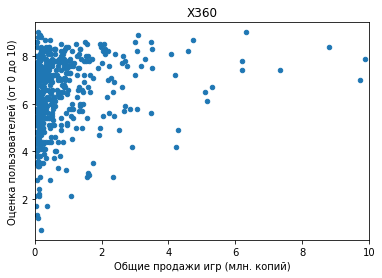

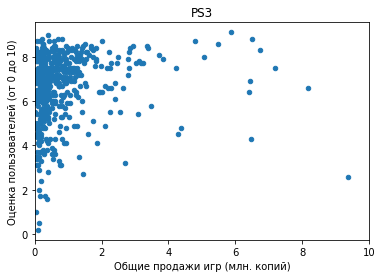

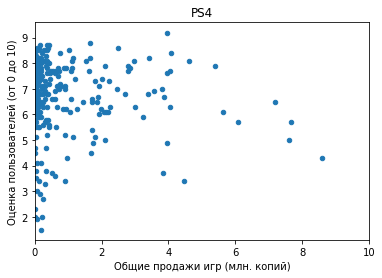

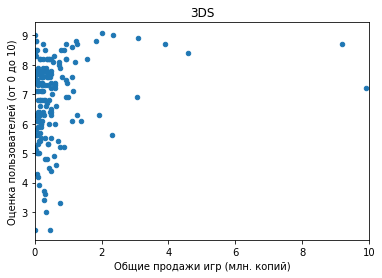

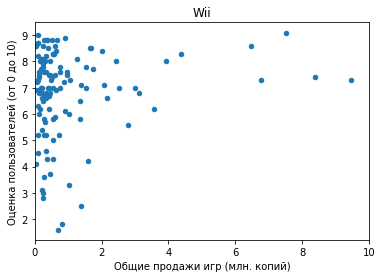

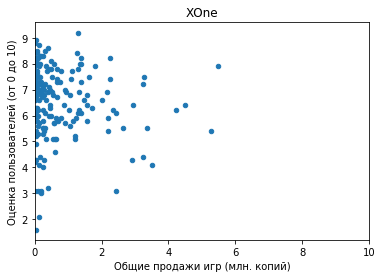

In [27]:
for platform in df_top_platforms['platform'].unique():
    df_top_platforms.loc[df_top_platforms['platform'] == platform].plot(kind='scatter', x='total_sales', y='user_score', title=platform)
    plt.xlim(0,10)
    plt.xlabel('Общие продажи игр (млн. копий)')
    plt.ylabel('Оценка пользователей (от 0 до 10)')
    plt.show()

Представленные графики подтверждают вывод по коэффициентам корреляции между оценками пользователей и количеством проданных копий игр. На графиках мы определили порог общих продаж в 10 млн. копий, чтобы более наглядно видеть распределение на диаграмме среднестатистических игр с продажами до 2 млн. копий.

На диаграммах рассеяния заметно небольшое смещение практически на всех графиках, кроме PS4. У игр с большим количеством проданных копий высокие оценки, но это не ярко выражено, что позволяет нам подтвердить вывод о слабой корреляции между оценками пользователей и количеством проданных копий игр на "топовых" платформах.

Рассмотрим диаграммы между оценками критиков и числом проданных копий по платформам.

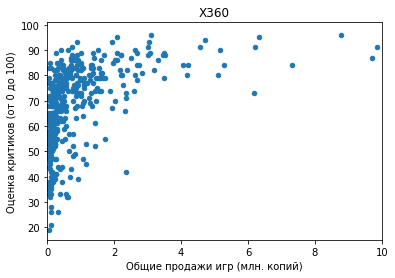

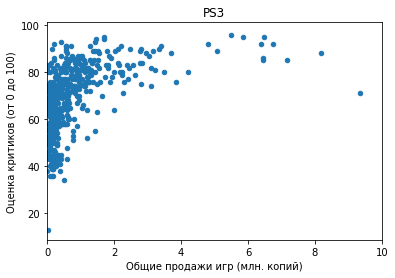

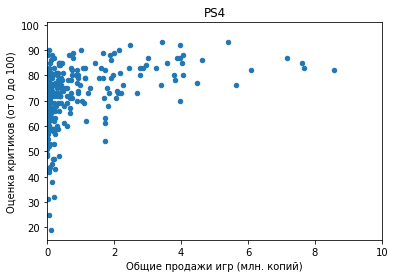

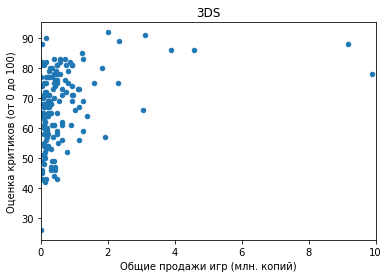

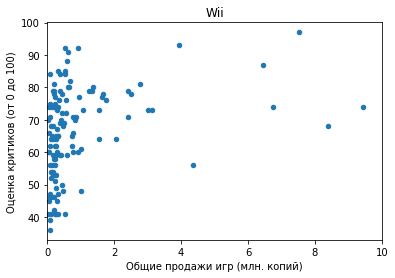

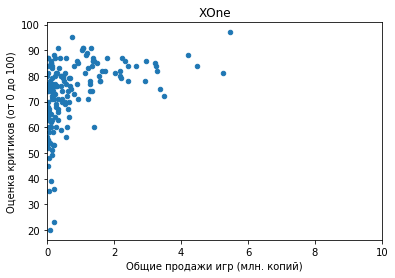

In [28]:
for platform in df_top_platforms['platform'].unique():
    df_top_platforms.loc[df_top_platforms['platform'] == platform].plot(kind='scatter', x='total_sales', y='critic_score', title=platform)
    plt.xlim(0,10)
    plt.xlabel('Общие продажи игр (млн. копий)')
    plt.ylabel('Оценка критиков (от 0 до 100)')
    plt.show()

**Вывод**

Таким образом, по коэффициентам корреляции можем говорить о том, что рейтинги игроков и критиков имеют слабую зависимость с общими продажами игр, оценки критиков и пользователей между собой также имеют относительно слабую зависимость, но на некоторых платформах ближе к средней (X360, PS3, 3DS).

По диаграммам также можно сказать, что зависимость общих продаж от оценки критиков невысокая, однако можно заметить, что игры с самыми высокими продажами по всем платформам имеют рейтинг выше 70%, что говорит о наличии связи между оценками критиков и продажами. В то же время, большинство игр имеют продажи до 2 миллионов копий и расположены размашисто по всей оси от 40% до 90% рейтинга.
____

Рассмотрим, как распределены игры по жанрам и выявим самые прибыльные, а также какие жанры выделяются сильнее других в положительную и отрицательную стороны.

In [29]:
# распределение игр по жанрам на актуальных платформах

df_games_by_genre = df_new.pivot_table(index='genre', values='name', aggfunc='count')
df_games_by_genre.sort_values(by='name', ascending=False)

,name
genre,
Action,1495
Misc,576
Sports,575
Role-Playing,568
Adventure,563
Shooter,410
Racing,237
Simulation,217
Fighting,199


Наибольшее число игр в выборке в жанре action, их количество почти в 3 раза превышает количество игр следующих по популярности жанров - misc, sports, role-playing, adventure. При этом количество указанных жанров игр практически одинаковое, на 150 позиций меньше игр в актуальном периоде жанра shooter, остальные жанры (racing, simulation, fighting, strategy, platform, puzzle) имеют в своих категориях от 114 до 237 наблюдений в датасете.

Рассмотрим средние и медианные продажи игр с группировкой по жанрам.

In [30]:
df_sales_by_genre = df_new.pivot_table(index='genre', values='total_sales', aggfunc=['mean','median'])
df_sales_by_genre.sort_values(by=('median', 'total_sales'), ascending=False)

,mean,median
,total_sales,total_sales
genre,,
Shooter,1.170098,0.385
Platform,0.782484,0.210
Sports,0.571113,0.200
Fighting,0.410000,0.180
Racing,0.517637,0.170
Role-Playing,0.555070,0.150
Action,0.450227,0.140
Misc,0.407222,0.130


Жанр Shooter имеет самое высокое значение средних общих продаж, а также медианное значение проданных копий игр, что говорит о самой высокой прибыльности среди игровых жанров.
На втором месте по средним и медианным продажам жанр платформеры, на третьем - спортивные игры.
Файтинги занимают по медианным продажам 4 често, а по среднему числу проданных копий конкретной игры они ниже ролевых игр, гонок и экшенов.

При этом, самым плохо продаваемым жанром можно считать адвентуры с самыми низкими показателями и средних и медианных общих продаж среди всех жанров, а также пазлы, которые располагаются на 2 месте с конца. Стратегии - на 3 месте с конца.

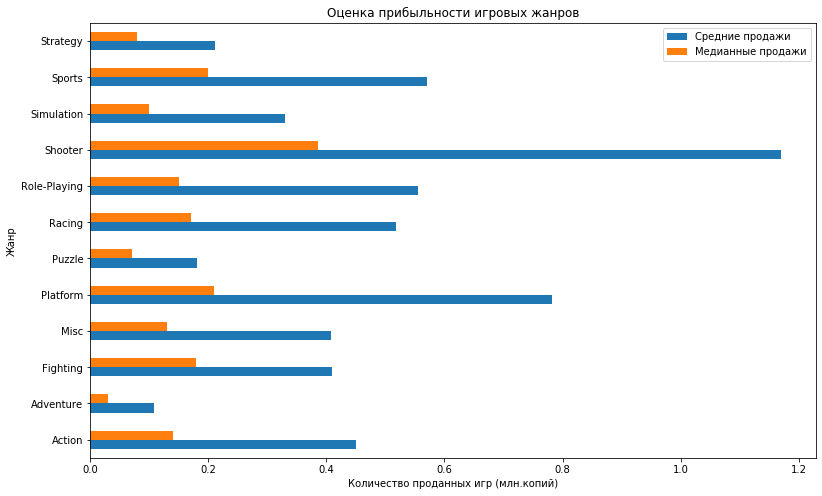

In [31]:
# визуальное представление прибыльности жанров игр
df_sales_by_genre.plot(kind='barh', figsize=(13,8))
plt.legend(["Средние продажи", "Медианные продажи"])
plt.xlabel('Количество проданных игр (млн.копий)')
plt.ylabel('Жанр')
plt.title('Оценка прибыльности игровых жанров')
plt.show()

**Вывод**

Таким образом, самым популярным жанром по количеству выпускаемых игр можно считать Action. За ним следуют адвентуры, спортивные игры, ролевые игры и игры жанра Misc (к данной категории относятся игры, которые нельзя определить другими жанрами).

Наименее популярными по количеству тайтлов являются игры жанров пазлы, стратегии, платформеры и файтинги.

Средние и медианным продажи по жанрам свидетельствуют о том, что самым прибыльным жанром является шутер, так как в среднем он имеет самый высокий показатель количества проданных копий, также и медианное значение в данном жанре самое высокое.

На втором месте - платформеры, что может быть связано с популярностью определенных тайтлов на портативных консолях, так как по количеству игр данный жанр оказался внизу списка. На третьем месте - спортивные игры, они имеют также высокий показатель количества выпущенных игр.

Внизу списка по прибыльности находятся жанры: адвентуры, пазлы, стратегии. По количеству тайтлов они также внизу списка. Невысокую популярность и низкую среднюю прибыльность данных жанров можно связать с более высоким порогом вхождения и отсутствием "развлекательности" в данных жанрах, они требуют напряженной работы мозга и не предполагают расслабление и отдых от мыслительных процессов.
___

**Общий вывод по исследовательскому анализу**

- Актуальными платформами на 2017 год будут PS4 и Xbox One, также актуальной является PC, так как жизненный цикл персональных компьютеров не зависит от выхода новых игровых платформ;
- Несмотря на высокие продажи в исторических данных, платформы PS3 Xbox360 Nintendo Wii и WiiU являются "умирающими", что позволяет сделать вывод о резком снижении продаж на игры на указанные платформы;
- Среди портативных платформ - самые высокие продажи у Nintendo 3DS, однако учитывая жизненный цикл платформ продажи на игры будут уменьшаться при выходе новых портативных платформ;
- Рейтинги игроков и критиков имеют слабую зависимость с общими продажами игр, оценки критиков и пользователей между собой также имеют низкий коэффициент корреляции. На некоторых платформах ближе к средней (X360, PS3, 3DS).
- Игры с самыми высокими продажами по всем платформам имеют рейтинг выше 70%, что говорит о наличии связи между оценками критиков и продажами. В то же время, большинство игр имеют продажи до 2 миллионов копий и расположены размашисто по всей оси от 40% до 90% рейтинга.
- Самыми прибыльными жанрами по показателям средних и медианных продаж являются шутеры, платформеры, спортивные игры. Не прибыльными по показателям являются адвентуры, пазлы и стратегии. По количеству выпущенных игр самый популярный жанр экшн, на втором месте адвентуры, меньше всего игр выпущено в жанрах платформеры, файтинги, стратегии и пазлы. Так как файтинги и платформеры являются достаточно прибыльными жанрами по показателям средних продаж, то можно сделать вывод, что в указанных жанрах имеются определенные популярные серии игр, которые способствуют высокой прибыльности жанров.

## Портрет пользователей рассматриваемых регионов ##

В датасете имеется разделение продаж по трем регионам: Северная Америка, Европа, Япония.

Чтобы эффективнее планировать рекламную кампанию на следующий год, необходимо учитывать пользовательские привычки и особенности, в том числе влияние возрастного рейтинга на продажу игр, популярность различных жанров и платформ.

Определим для пользователей каждого региона:

- Самые популярные платформы (топ-5).
- Самые популярные жанры (топ-5).
- Влияние возрастного рейтинга ESRB на продажи в отдельных регионах.

In [32]:
# список популярных платформ по количеству проданных игр по регионам

platform_sales_by_region = df_new.pivot_table(index='platform', values=['eu_sales', 'jp_sales', 'na_sales'], aggfunc='sum')
eu_top_platforms = platform_sales_by_region.sort_values(by='eu_sales',ascending=False)['eu_sales'].head(5)
na_top_platforms = platform_sales_by_region.sort_values(by='na_sales',ascending=False)['na_sales'].head(5)
jp_top_platforms = platform_sales_by_region.sort_values(by='jp_sales',ascending=False)['jp_sales'].head(5)

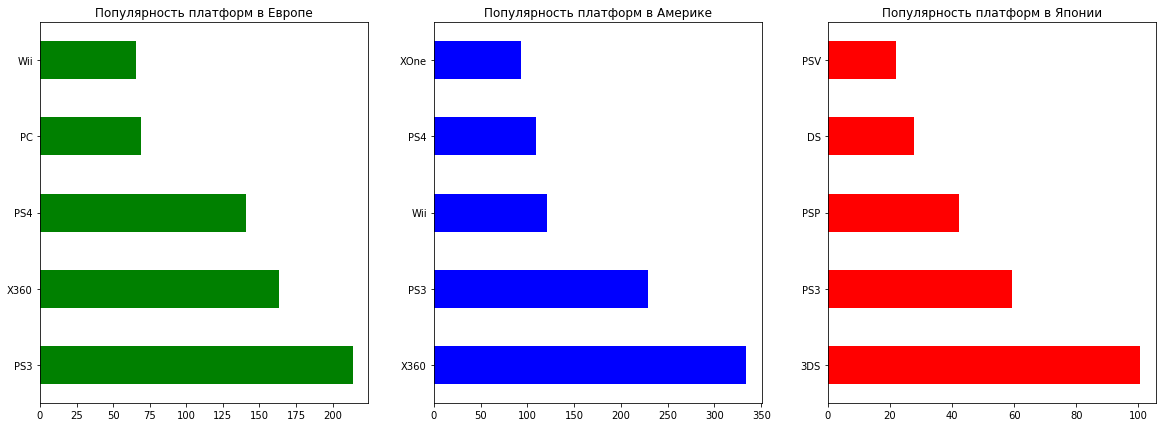

In [33]:
fig, axes = plt.subplots(1,3, figsize=(20,7))
eu_top_platforms.plot(kind='barh', ax=axes[0], subplots=True, legend=False, color='green')
na_top_platforms.plot(kind='barh',ax=axes[1], subplots=True, legend=False, color='blue')
jp_top_platforms.plot(kind='barh',ax=axes[2], subplots=True, legend=False, color='red')
axes[0].set_title('Популярность платформ в Европе')
axes[1].set_title('Популярность платформ в Америке')
axes[2].set_title('Популярность платформ в Японии')

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

plt.show()

На столбцовых диаграммах представлены топ-5 платформ по количеству проданных игр за актуальный период в каждом из рассматриваемых регионов:

* В Европе: PS3 - Xbox360 - PS4 - PC - Nintendo Wii
* В Америке: Xbox360 - PS3 - Nintendo Wii - PS4 - Xbox One
* В Японии: Nintendo 3DS - PS3 - PSP - DS - PSV

Можно сделать вывод, что в Европе и Америке популярнее игры на консоли и платформы стационарные, которые используются дома и подключаются к телевизору/монитору. В Японии в топе продаж игры на портативные платформы, причем весь список платформ от Японских производителей (Sony и Nintendo), платформы компании Microsoft не пользуются популярностью Японии.

Рассмотрим популярность проданных игр по жанрам в разных регионах.

In [34]:
# списки популярных жанров по регионам

top_genre_eu = df_new.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_genre_na = df_new.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
top_genre_jp = df_new.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)

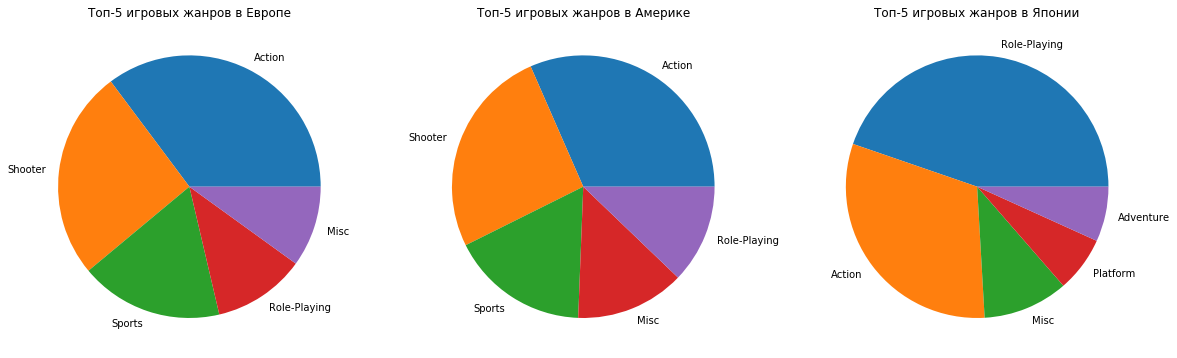

In [35]:
fig, axes = plt.subplots(1,3, figsize=(20,7))
top_genre_eu.plot(kind='pie', ax=axes[0], subplots=True, legend=False)
top_genre_na.plot(kind='pie',ax=axes[1], subplots=True, legend=False)
top_genre_jp.plot(kind='pie',ax=axes[2], subplots=True, legend=False)
axes[0].set_title('Топ-5 игровых жанров в Европе')
axes[1].set_title('Топ-5 игровых жанров в Америке')
axes[2].set_title('Топ-5 игровых жанров в Японии')

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

plt.show()

Популярные жанры в Европе и Америке идентичны, в топе находятся экшены, шутеры, спортивные игры. Жанры Misc и ролевые игры занимают 4 и 5 строчки со схожей долей, при этом в Европе ролевые игры немного популярнее, а в Америке игры жанра Misc.

В Японии также в топе присутствует жанр Action, однако он на втором месте после ролевых игр. Можно предположить, что популярность жанра ролевых игр связана с наличием большого количества тайтлов на 3DS в жанре JRPG (japan role-playing game), к которым относятся такие серии игр, как покемоны, dragon quest, SMT, FF и т.п., жанр платформеров не популярен на Западе, но занимает 4 строчку в Японии, что также связано с популярностью портативных консолей, на которых больше тайтлов данного жанра и в них комфортно играть в дороге.

Рассмотрим, как влияет возрастной рейтинг на продажи игр в разных регионах, напомним себе значения букв в рейтингах:

- EC (Early childhood) - "для детей младшего возраста (от 3 лет)"
- E (Everyone) - "для всех (от 6 лет)"
- E10+ (Everyone 10 and older) - "для всех от 10 лет и старше"
- T (Teen) - "для подростков (от 13 лет)"
- M (Mature) - "для взрослых (от 17 лет)"
- AO (Adults only) - "только для взрослых (от 18 лет)"
- RP (Rating Pending) - "рейтинг ожидается" (ожидает присвоения рейтинга)

Заполним пропуски игр с пропущенным рейтингом на "нет рейтинга"

In [50]:
# заполнение пропусков в рейтинге

df_filled_rating = df_new
df_filled_rating.loc[df_filled_rating['rating'].isna(), 'rating'] = 'нет рейтинга'

In [51]:
# Общие продажи в регионах по рейтингам

df_filled_rating.pivot_table(index='rating', values=['eu_sales','na_sales','jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
rating,,,
E,197.34,47.87,271.15
E10+,99.28,13.22,159.38
EC,0.00,0.00,1.13
M,292.04,30.45,382.22
RP,0.03,0.00,0.00
T,113.08,42.11,160.81
нет рейтинга,139.44,171.49,155.72


По таблице мы видим, что игры без определенного рейтинга имеют достаточно высокие продажи, в сумме соизмеримые с играми с указанным рейтингом.

Рассмотрим игры с рейтингом EC и RP, так как игры с указанными рейтингами имеют аномально низкие продажи

In [53]:
df_filled_rating.query('rating == "EC" or rating == "RP"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
4297,Nickelodeon Team Umizoomi,DS,2011,Action,0.42,0.00,0.0,0.03,NaN,NaN,EC,0.45
5034,Sesame Street: Elmo's A-to-Zoo Adventure,Wii,2010,Misc,0.35,0.00,0.0,0.02,NaN,NaN,EC,0.37
6046,Sesame Street: Cookie's Counting Carnival,Wii,2010,Misc,0.27,0.00,0.0,0.02,NaN,NaN,EC,0.29
13065,Sesame Street: Cookie's Counting Carnival,PC,2010,Misc,0.05,0.00,0.0,0.00,NaN,NaN,EC,0.05
13455,Sesame Street: Elmo's A-to-Zoo Adventure,PC,2010,Misc,0.04,0.00,0.0,0.00,NaN,NaN,EC,0.04
14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.00,0.03,0.0,0.01,63.0,6.8,RP,0.04


Игры с рейтингом EC (для детей младшего возраста) - это игры про улицу Сезам и одна игра от nickelodeon, они продаются только в Америке, в Европе и Японии их продажи равны нулю.

С рейтингом RP только одна игра, стратегия 2011 года на PC. RP - означает, что рейтинг игре не присвоен.

Рассмотрим, какие игры без рейтинга имеют высокие продажи

In [66]:
# игры без рейтинга с высокими продажами

df_filled_rating.query('rating == "нет рейтинга" & total_sales > 1').sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,нет рейтинга,7.14
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.71,1.46,0.06,0.58,NaN,NaN,нет рейтинга,2.81
278,FIFA 12,X360,2011,Sports,0.84,2.78,0.02,0.53,NaN,NaN,нет рейтинга,4.17
1290,LEGO City Undercover,3DS,2013,Platform,0.52,0.77,0.07,0.11,NaN,NaN,нет рейтинга,1.47
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,нет рейтинга,14.63
831,Toy Story 3: The Video Game,DS,2010,Action,0.89,0.94,0.02,0.21,NaN,NaN,нет рейтинга,2.06
563,Yokai Watch 2 Shinuchi,3DS,2014,Role-Playing,0.00,0.00,2.68,0.00,NaN,NaN,нет рейтинга,2.68
910,Tomb Raider (2013),X360,2013,Action,0.86,0.84,0.01,0.17,NaN,NaN,нет рейтинга,1.88
1861,Omerta: City of Gangsters,PS3,2011,Simulation,0.52,0.42,0.00,0.15,NaN,NaN,нет рейтинга,1.09
180,Minecraft,PS3,2014,Misc,2.03,2.37,0.00,0.87,NaN,NaN,нет рейтинга,5.27


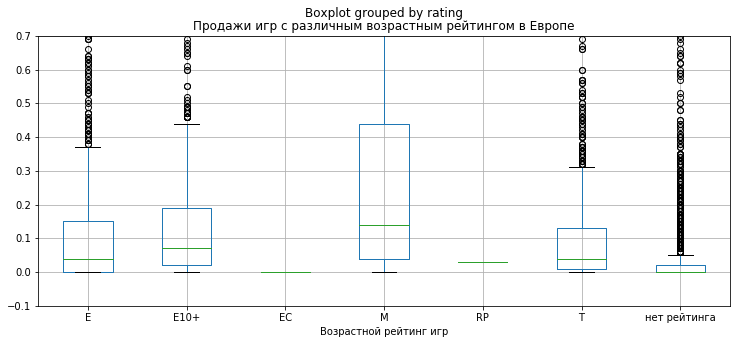

In [57]:
# пострение диаграммы размаха по рейтингу для Европы

df_filled_rating.boxplot('eu_sales', by='rating', figsize=(12,5))
plt.ylim(-0.1,0.7)
plt.xlabel('Возрастной рейтинг игр')
plt.title('Продажи игр с различным возрастным рейтингом в Европе')
plt.show()

По диаграмме видно, что наибольший размах и медианное значение наблюдается в играх с рейтингом Mature (для взрослых). Можно сделать вывод, что в Европейской части преобладают взрослые игроки. Следом идут по размаху и медианным значениям игры с рейтингом от 10 лет, от 6 лет и для подростков (от 13 лет).

Игры без рейтинга, несмотря на высокие совокупные продажи (139,4 млн. копий), имеют низкие средние продажи, так как по боксплоту видно, что у таких игр самый маленький размах значений и медиана, близкая к нулевому значению. При этом у игр без рейтинга широкая линия аномальных значений. Игры без рейтинга с высокими продажами - это популярные во всем мире тайтлы, по которым отсутствует информация о рейтинге. При этом в срез попадают как Японские игры, которые предположительно могли не оцениваться по системе ESRB (Покемоны), так и Американские и Европейские тайтлы (Lego, FIFA, Minecraft), в которых пропуски могли появится по техническим причинам, либо из-за отсутствия информации в первоначальном источнике.

Таким образом, для пользователей из Европы ограничения по возрасту не уменьшают продажи игр, так как самыми продаваемыми являются игры с возврастным рейтингом от 17 лет.

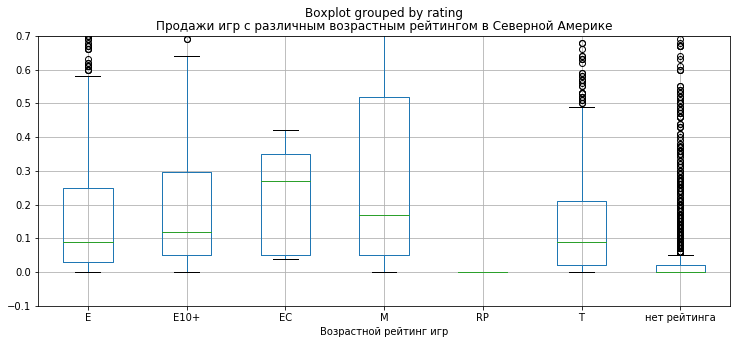

In [58]:
# пострение диаграммы размаха по рейтингу для Америки

df_filled_rating.boxplot('na_sales', by='rating', figsize=(12,5))
plt.ylim(-0.1,0.7)
plt.xlabel('Возрастной рейтинг игр')
plt.title('Продажи игр с различным возрастным рейтингом в Северной Америке')
plt.show()

В Америке аналогично самый большой размах наблюдается у игр с рейтингом Mature. 
Самое большое медианное значение у игр с рейтингом для маленьких детей (от 3 лет), это рассмотренные выше игры об улице Сезам и 1 детская игра Nickelodeon, которые имеют относительно высокие продажи в Америке и не продаются в других регионах.

В данном случае также сложно сказать о влиянии рейтинга на продажи, в связ с широким размахом у игр для взрослой аудитории и самым большим числом проданных копий из всех рейтинговых категорий.

Можно предположить, что игры для тинейджеров и взрослой аудитории затрагивают более глубокие темы без ограничений в творческом представлении сюжетной тематики, поэтому такие тайтлы имеют наибольшие продажи.

С играми без рейтинга аналогичная ситуация, как и в Европейском регионе. Медиана равна нулю, узкий размах значений и больше количество аномалий.

Также, в Америке, в отличие от Европы, заметно выше общее число продаж по играм с рейтингами E и E10+ (для всех от 6 лет и для всех от 10 лет).

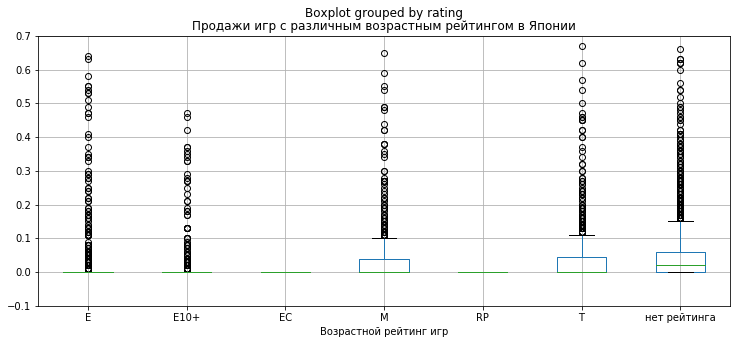

In [67]:
# пострение диаграммы размаха по рейтингу для Японии

df_filled_rating.boxplot('jp_sales', by='rating', figsize=(12,5))
plt.ylim(-0.1,0.7)
plt.xlabel('Возрастной рейтинг игр')
plt.title('Продажи игр с различным возрастным рейтингом в Японии')
plt.show()

Несмотря на высокие продажи игр в Японии на платформы, которые мы определили ранее, значения продаж игр с различными рейтингами в сумме намного ниже, чем в Европе и Америке. Медианные значения по графику близки либо равны нулю.

Можно сделать вывод, что тайтлы популярные в Европе и Америке не продаются в Японии, а на Японских тайтлах либо не указан возрастной рейтинг по используемой в датасете градации, либо используется другой рейтинг и поэтому данные по ним отсутствуют.

В Японии игры без рейтинга имеют достаточно широкий размах и медианное значение. Здесь будет справедливым предположение, что популярные Японские игры не имеют оценки рейтинга по системе ESRB. Также, в Японии самые высокие совокупные продажи имеют игры без рейтинга (171,5 млн. копий), что в 3-5 раз превышает продажи в других категориях.

Для Японского рынка можно говорить об отсутствии влияния возрастного рейтинга по системе ESRB на продажи игр. Здесь самой доходной категорией являются игры с отсутствующим рейтингом.

**Вывод**

Пользователи в Европе и Америке схожи по своим предпочтениям - это приверженцы стационарных консолей (PS3, Xbox360, PS4, Wii). В Европе в топ-5 также входят игры на персональные компьютеры, в Америке Xbox One.

По жанрам Европейские и Американские игроки имеют полное соответствие в предпочтениях, самые популярные жанры в обоих регионах это экшены, шутеры, спортивные игры, ролевые игры и игры прочих жанров (Miscellaneous games).

В Японии предпочтения пользователей более специфичные, в связи с национальными особенностями люди предпочитают портативные консоли и консоли Японского производства, самой популярной платформой является Nintendo 3DS с большим отрывом и количеством проданных игр 100 млн. копий, на втором месте стационарная платформа PS3, остальные места в топе занимают также портативные консоли (по порядку): PSP (42 млн проданных игр), DS (старший "брат" 3DS, предыдущее поколение портативной консоли с 28 млн. копий, PSV (портативная версия консоли PS3 с 22 млн. копий).

Среди популярных жанров в Японии на первом месте с большим отрывом ролевые игры и на втором месте экшены. Далее с меньшей долей жанры Misc, platformers, adventure games.
_____

## Проверка гипотез

На данном этапе проверим следующие гипотезы:

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Гипотеза - "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

Сформулируем нулевую и альтернативную статистические гипотезы для проверки:
* Нулевая гипотеза - Средние пользовательские оценки Xbox One и PC равны
* Альтернативная гипотеза - Средние пользовательские оценки Xbox One и PC различаются

В этом случае проверку можно выполнить с помощью t-теста, так как он позволяет сравнивать средния значения двух несвязных между собой выборок и на основе результата теста сделать заключение о статистическом различии между ними.

Прежде чем приступать к расчету p-значения и определения порогового уровня критерия значимости, необходимо очистить датасет от пропусков и разделить две выборки: оценки по играм для Xbox One и оценки по играм для PC

In [42]:
# очистка датасета от пропусков

df_hyp = df_new.dropna()

# выборки для сравнения

xone_scores = df_hyp.query('platform == "XOne"')['user_score']
pc_scores = df_hyp.query('platform == "PC"')['user_score']

Определим критический уровень значимости alpha, считаем целесообразным установить его на уровне 0.05 и проверим гипотезу при помощи t-теста

In [43]:
# проверка гипотезы
alpha = .05
result_one = st.ttest_ind(xone_scores, pc_scores, equal_var=True)

print(f'p-значение {result_one.pvalue}')

if result_one.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Гипотеза не отвергнута')

p-значение 0.9170685431405989
Гипотеза не отвергнута


По результатам теста, мы видим, что p-значение крайне высокое (98%), что позволяет сделать вывод о том, что нулевую гипотезу нельзя отвергнуть - средние пользовательские оценки xbox one и pc с высокой вероятностью равны.

Игры для Xbox One и PC - это в основном мультиплатформенные продукты компании Microsoft и прочих студий, выпускающих игры преимущественно на PC и других основных стационарных платформах (PS4, Xbox One, Xbox 360, PS3), поэтому логично, что оценки на игры для сравниваемых платформ схожи.

### Гипотеза - "Средние пользовательские рейтинги жанров Action и Sports разные"

Определим нулевую и альтернативную гипотезу, в данном случае они будут звучать следующим образом:

* Нулевая гипотеза - Средние пользовательские рейтинги жанра Action равны рейтингам жанра Sports
* Альтернативная гипотеза - Средние пользовательские рейтинги жанра Action не равны рейтингам жанра Sports

Здесь также сравниваются 2 разные выборки, в одной оценки на игры жанра Sports, в другой - оценки на игры жанра Action. Будем использовать те же методы, что и при проверке предыдущей гипотезы. Уровень значимости оставим 0.05

In [44]:
# выборки для сравнения

sport_scores = df_hyp.query('genre == "Sports"')['user_score']
action_scores = df_hyp.query('genre == "Action"')['user_score']

In [45]:
# проверка гипотезы

result_two = st.ttest_ind(sport_scores, action_scores, equal_var=True)

print(f'p-значение {result_two.pvalue}')

if result_two.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Гипотеза не отвергнута')

p-значение 1.5044454579465404e-10
Отвергаем нулевую гипотезу


p-значение практически равно нулю, поэтому мы предполагаем, что нулевая гипотеза не верна и говорим о том, что средние пользовательские оценки в жанрах Action и Sports возможно не равны, значит с большей вероятностью мы можем предположить верность альтернативной гипотезы - средние пользовательские оценки жанра Action не равны оценкам игр жанра Sports.

Посмотрим, как различаются средние оценки по жанрам

In [46]:
print('Средняя оценка по спортивным играм:', sport_scores.mean())
print('Средняя оценка по играм жанра экшн:', action_scores.mean())

Средняя оценка по спортивным играм: 6.175619834710743
Средняя оценка по играм жанра экшн: 6.829777777777778


По средней мы видим, что пользовательские оценки экшенов статистически выше, чем по играм жанра спорт.

## Вывод

По результатам исследования были получены следующие выводы:

- Актуальными платформами на 2017 год будут PS4 и Xbox One, также актуальной является PC, так как жизненный цикл персональных компьютеров не зависит от выхода новых игровых платформ;
- Несмотря на высокие продажи в исторических данных, платформы PS3 Xbox360 Nintendo Wii и WiiU являются "умирающими", что позволяет сделать вывод о резком снижении продаж на игры на указанные платформы;
- Среди портативных платформ - самые высокие продажи у Nintendo 3DS, однако учитывая жизненный цикл платформ продажи на игры будут уменьшаться при выходе новых портативных платформ;
- У пользователей Японии предпочтения в жанрах и используемых платформах отличаются от пользователей Европы и Северной Америки, которые имеют схожие предпочтения;
- Японские пользователи предпочитают Японские платформы, 4 из 5 топовых платформ по историческим данным относятся к портативным, кроме PS3. 
- Среди жанров, на Западе самым популярными является Action, shooter, sports. В Японии RPG и action.
- При помощи статистической проверки была опровегнута гипотеза о равенстве пользовательских оценок на экшены и спортивные игры, оценки отличаются, у экшенов средняя оценка выше;
- Xbox One и PC с большой вероятностью имеют одинаковые средние оценки на игры, что логично, так как на Xbox One и PC выпускаются схожие мультиплатформенные тайтлы.
- Игры с высоким возрастным рейтингом или общим (от 6 лет) имеют более высокие средние продажи, чем игры для детей.
- На продажи игр в Японии рейтинг ESRB не оказывает влияния, так как игры с пропусками в рейтингах в совокупности имеют в 3-5 раз больше проданных копий, чем игры других категорий.